In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from sklearn.cluster import KMeans
from skimage.color import rgb2gray
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

### (a) This assignment uses a convolutional neural network for image colorization which turns a grayscale image to a colored image By converting an image to grayscale, we loose color information, so converting a grayscale image back to a colored version is not an easy job. We will use the CIFAR-10 dataset. Downolad the dataset from http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz.

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [3]:
print("The shape of X_train:",X_train.shape)
print("The shape of y_train:",y_train.shape)
print("The shape of X_test:",X_test.shape)
print("The shape of y_test:",y_test.shape)

The shape of X_train: (50000, 32, 32, 3)
The shape of y_train: (50000, 1)
The shape of X_test: (10000, 32, 32, 3)
The shape of y_test: (10000, 1)


### (b) From the train and test dataset, extract the class birds. We will focus on this class, which has 6000 members.

In [4]:
bird_idx_train, _ = np.where(y_train == 2)
bird_idx_test, _ = np.where(y_test == 2)

X_train_bird, y_train_bird = X_train[bird_idx_train], y_train[bird_idx_train]
X_test_bird, y_test_bird = X_test[bird_idx_test], y_test[bird_idx_test]

print("The shape of bird X_train:",X_train_bird.shape)
print("The shape of bird y_train:",y_train_bird.shape)
print("The shape of bird X_test:",X_test_bird.shape)
print("The shape of bird y_test:",y_test_bird.shape)

The shape of bird X_train: (5000, 32, 32, 3)
The shape of bird y_train: (5000, 1)
The shape of bird X_test: (1000, 32, 32, 3)
The shape of bird y_test: (1000, 1)


In [5]:
X_df = np.concatenate([X_train_bird, X_test_bird])
y_df = np.concatenate([y_train_bird, y_test_bird])

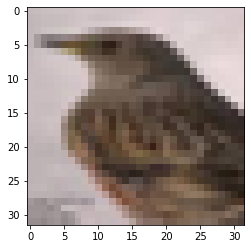

In [6]:
plt.imshow(X_df[2])

### (c) Those 6000 images have 6000 x 32 x 32 pixels. Choose at least 10% of the pixels randomly. It is strongly recommended that you choose a large number or all of the pixels. You will have between P = 614400 and P = 6144000 pixels. Each pixel is an RGB vector with three elements.

### Selecting all pixels

### (d) Run k-means clustering on the P vectors using k = 4. The centers of the clusters will be your main colors. Convert the colored images to k-color images by converting each pixel's value to the closest main color in terms of Euclidean distance. These are the outputs of your network, whose each pixel falls in one of those k classes.

In [7]:
X_data = X_df.reshape(-1, 3)
kmeans = KMeans(n_clusters=4, random_state=2333, n_init=10).fit(X_data)
main_colors = kmeans.cluster_centers_
y_predict = kmeans.labels_

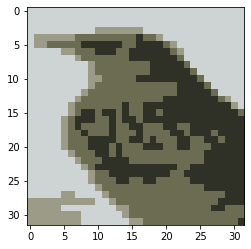

In [8]:
X_converted = np.array([main_colors[y_predict[i]] for i in range(len(X_data))], dtype=np.uint8).reshape(-1, 32, 32, 3)
plt.imshow(X_converted[2])

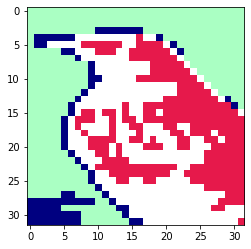

In [9]:
distinct_color = np.array([[0,0,128],[230,25,75],[170,255,195],[255,255,255]], dtype=np.uint8)
X_suggested = np.array([distinct_color[y_predict[i]] for i in range(len(X_data))], dtype=np.uint8).reshape(-1, 32, 32, 3)
plt.imshow(X_suggested[2])


### (e) Use any tool (e.g., openCV or scikit-learn) to obtain grayscale 32x 32 x1 images from the original 32 x 32 x 3 images. The grayscale images are inputs of your network.

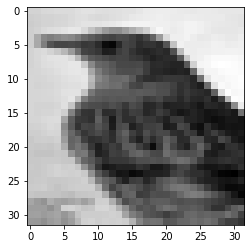

In [10]:
X_grayscale = np.array([rgb2gray(X_df[i]) for i in range(len(X_df))])
plt.imshow(X_grayscale[2], cmap=plt.cm.gray)

### (f) Plot training, (validation), and test errors in each epoch.Report the train and test errors and visually compare the artificially colored versions of the first 10 images in the test set with the original images.

### Converting to grayscale

In [11]:
encoder = OneHotEncoder(handle_unknown='ignore')
y_sample = [[0], [1], [2], [3]]
encoder.fit(y_sample)
y_encoded = encoder.transform(y_predict.reshape(-1, 1)).toarray().astype(int).reshape(-1, 32, 32, 4)
X_train_grayscale, X_test_grayscale, y_train_grayscale, y_test_grayscale = train_test_split(X_grayscale.reshape(-1, 32, 32, 1), y_encoded, test_size=0.1, random_state=666)
print("The shape of grayscale X_train:",X_train_grayscale.shape)
print("The shape of grayscale y_train:",y_train_grayscale.shape)
print("The shape of grayscale X_test:",X_test_grayscale.shape)
print("The shape of grayscale y_test:",y_test_grayscale.shape)

The shape of grayscale X_train: (5400, 32, 32, 1)
The shape of grayscale y_train: (5400, 32, 32, 4)
The shape of grayscale X_test: (600, 32, 32, 1)
The shape of grayscale y_test: (600, 32, 32, 4)


In [12]:
model = keras.models.Sequential()
model.add(Conv2D(filters=64, kernel_size=(5,5), strides=(1, 1), padding='same', activation='relu', input_shape=(32,32,1)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'))
model.add(Conv2D(filters=64, kernel_size=(5,5), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'))
model.add(Dense(32, activation="softmax"))
model.add(Dense(4, activation="softmax"))
model.compile(optimizer=keras.optimizers.SGD(0.001), loss='categorical_crossentropy', metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dense (Dense)                (None, 32, 32, 32)        2080      
_________________________________________________________________
dense_1 (Dense)              (None, 32, 32, 4)         132       
Total params: 106,340
Trainable params: 106,340
Non-trainable params: 0
__________________________________________________

In [13]:
number_of_epochs = 30
output_directory = "./cnn_checkpoint"
if not os.path.exists(output_directory):
    os.mkdir(output_directory)
    
path = os.path.join(output_directory, 'ck_{epoch:02d}.hdf5')
checkpoint = keras.callbacks.ModelCheckpoint(filepath = path,save_weights_only= True)
earlyStoppingCk = keras.callbacks.EarlyStopping(patience = 5, min_delta = 1e-4)

history = model.fit(X_train_grayscale, y_train_grayscale, epochs=number_of_epochs, validation_data=(X_test_grayscale, y_test_grayscale), callbacks=[checkpoint, earlyStoppingCk])

Epoch 1/30
169/169 [==============================] - 33s 11ms/step - loss: 1.3864 - accuracy: 0.3384 - val_loss: 1.3844 - val_accuracy: 0.3363
Epoch 2/30
169/169 [==============================] - 2s 9ms/step - loss: 1.3828 - accuracy: 0.3374 - val_loss: 1.3812 - val_accuracy: 0.3363
Epoch 3/30
169/169 [==============================] - 2s 9ms/step - loss: 1.3796 - accuracy: 0.3374 - val_loss: 1.3783 - val_accuracy: 0.3363
Epoch 4/30
169/169 [==============================] - 2s 9ms/step - loss: 1.3766 - accuracy: 0.3374 - val_loss: 1.3756 - val_accuracy: 0.3363
Epoch 5/30
169/169 [==============================] - 2s 9ms/step - loss: 1.3739 - accuracy: 0.3374 - val_loss: 1.3731 - val_accuracy: 0.3363
Epoch 6/30
169/169 [==============================] - 2s 9ms/step - loss: 1.3714 - accuracy: 0.3374 - val_loss: 1.3708 - val_accuracy: 0.3363
Epoch 7/30
169/169 [==============================] - 2s 9ms/step - loss: 1.3691 - accuracy: 0.3374 - val_loss: 1.3688 - val_accuracy: 0.3363
Epoc

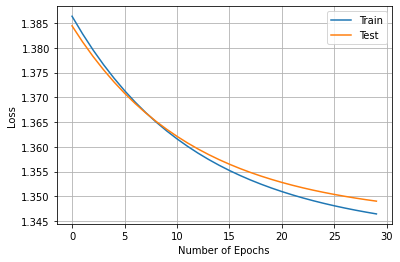

In [14]:
def plot_error_curves(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.grid(True)
    plt.gca()
    plt.ylabel('Loss')
    plt.xlabel('Number of Epochs')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()
    
plot_error_curves(history)

In [15]:
y_pred_color = model.predict(X_test_grayscale)
y_pred_color = y_pred_color.reshape(X_test_grayscale.shape[0] * 32 * 32, 4)
output_images = []
for index in range(len(y_pred_color)):
    output_images.append([int(color) for color in main_colors[np.argmax(y_pred_color[index])]])
    
y_test_new = y_test_grayscale.reshape(X_test_grayscale.shape[0] * 32 * 32, 4)
y_test_k_color = []
for i in range(len(y_test_new)):
    y_test_k_color.append([int(color) for color in main_colors[np.argmax(y_test_new[i])]])
output_images = np.reshape(output_images, (-1, 32, 32, 3))
y_test_k_color = np.reshape(y_test_k_color, (-1, 32, 32, 3))

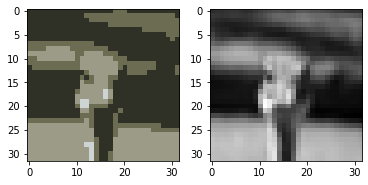

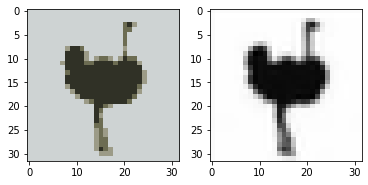

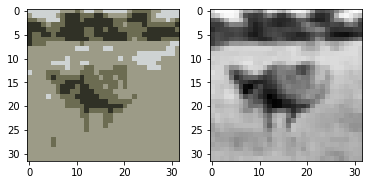

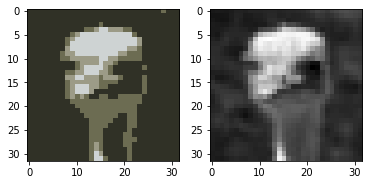

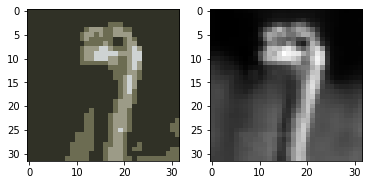

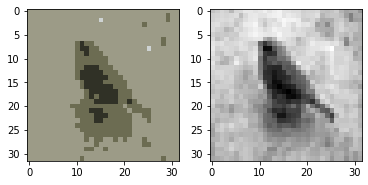

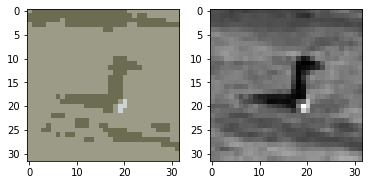

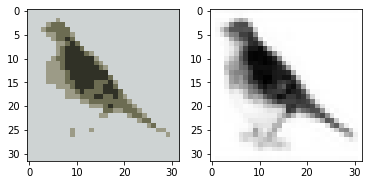

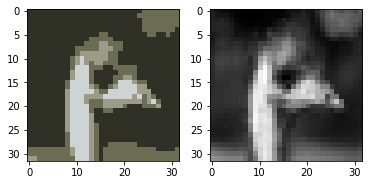

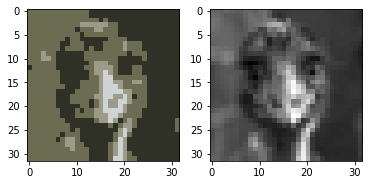

In [16]:
for i in range(10):
  fig, axes = plt.subplots(1, 2)
  axes[0].imshow(y_test_k_color[i])
  axes[1].imshow(X_test_grayscale.reshape(-1,32,32)[i], cmap=plt.cm.gray)
  plt.show()